In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os


In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
import os
import shutil
import random

def split_images(source_folder, train_folder, test_folder, split_ratio=0.8):
    # Create train and test folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # List all files in the source folder
    files = os.listdir(source_folder)
    random.shuffle(files)  # Shuffle the files to randomize the order

    # Calculate the number of images for training and testing
    num_train = int(len(files) * split_ratio)
    train_files = files[:num_train]
    test_files = files[num_train:]

    # Move training images to the train folder
    for file in train_files:
        source_path = os.path.join(source_folder, file)
        dest_path = os.path.join(train_folder, file)
        shutil.copyfile(source_path, dest_path)

    # Move testing images to the test folder
    for file in test_files:
        source_path = os.path.join(source_folder, file)
        dest_path = os.path.join(test_folder, file)
        shutil.copyfile(source_path, dest_path)

    print("Images have been split successfully.")

# Example usage:
source_folder = "images/"
train_folder = "dataset/train/"
test_folder = "dataset/val/"
split_ratio = 0.8  # 80% training, 20% testing

if "dataset" in os.listdir():
    shutil.rmtree("dataset")
    
for i in os.listdir(source_folder):
    split_images(source_folder+i, train_folder+i, test_folder+i, split_ratio)


Images have been split successfully.
Images have been split successfully.
Images have been split successfully.
Images have been split successfully.
Images have been split successfully.


In [4]:
# Define the data directory
data_dir = 'dataset/'
 
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 3452, 'val': 865}


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\8th sem\projects\Flower_recog_Model\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training loop
import datetime

start_time = datetime.datetime.now().minute
num_epochs = 30
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
end_time = datetime.datetime.now().minute
print("Training complete! in", end_time-start_time)

train Loss: 1.2277 Acc: 0.5878
val Loss: 0.5628 Acc: 0.8139
train Loss: 0.9349 Acc: 0.6677
val Loss: 0.3963 Acc: 0.8717
train Loss: 0.8751 Acc: 0.6973
val Loss: 0.3838 Acc: 0.8682
train Loss: 0.8387 Acc: 0.7103
val Loss: 0.4231 Acc: 0.8636
train Loss: 0.8724 Acc: 0.7028
val Loss: 0.4285 Acc: 0.8590
train Loss: 0.8065 Acc: 0.7178
val Loss: 0.4958 Acc: 0.8393
train Loss: 0.7973 Acc: 0.7231
val Loss: 0.3589 Acc: 0.8844
train Loss: 0.8139 Acc: 0.7193
val Loss: 0.3880 Acc: 0.8728
train Loss: 0.8008 Acc: 0.7225
val Loss: 0.5229 Acc: 0.8335
train Loss: 0.7838 Acc: 0.7268
val Loss: 0.3515 Acc: 0.8832
train Loss: 0.8067 Acc: 0.7283
val Loss: 0.3594 Acc: 0.8867
train Loss: 0.8170 Acc: 0.7193
val Loss: 0.4808 Acc: 0.8474
train Loss: 0.8238 Acc: 0.7303
val Loss: 0.4361 Acc: 0.8566
train Loss: 0.8507 Acc: 0.7141
val Loss: 0.3746 Acc: 0.8775
train Loss: 0.8173 Acc: 0.7199
val Loss: 0.4382 Acc: 0.8671
train Loss: 0.8136 Acc: 0.7231
val Loss: 0.3500 Acc: 0.9017
train Loss: 0.7504 Acc: 0.7373
val Loss:

In [12]:

# Save the model
torch.save(model.state_dict(), 'flower_classification_model.pth')


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [23]:
import torch
from torchvision import models, transforms
import torch.nn as nn
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




In [24]:
# Load and preprocess the unseen image
# image_path = 'Sample/lily-flower.jpg'  # Replace with the path to your image
image_path = 'dataset/val/rose/5349254467_388ff94f8b_n.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

Perform inference using the model:

In [25]:
import os
class_names = list()
for val in os.listdir('dataset/val/'): 
    class_names.append(val)
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [26]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
# class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

# Get class probabilities
probabilities = F.softmax(output[0], dim=0)
# Load class labels (assuming you have them)
flower_names = class_names

# Get the predicted class index and its probability
predicted_class_idx = torch.argmax(probabilities).item()
predicted_probability = probabilities[predicted_class_idx].item()

# Generate the outcome string
outcome = f"The image belongs to {class_names[predicted_class_idx]} with a score of {predicted_probability*100:.2f}%."

print(f'The predicted class is: {predicted_class_name} with \n{outcome}')


The predicted class is: rose with 
The image belongs to rose with a score of 99.67%.


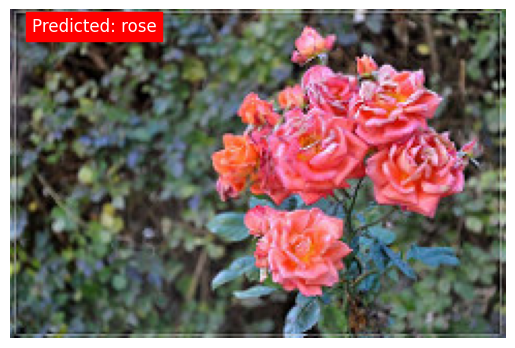

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()